In [167]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
fig_dir = 'figures/'
import sys
sys.path.append(module_path)
import time
import datetime
import importlib
import random
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

import model_management
%load_ext autoreload
%autoreload 1
%aimport data_processing
%aimport plotting
%aimport keras_objects
%aimport pso
# %aimport pso_parallel_training_queue
from data_processing import *
from plotting import *
from keras_objects import *
from pso import *
# from pso_parallel_training_queue import *

np.random.seed(999)
random.seed(999)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
### General parameters
total_set_size = 3e3 # how many examples will be used for training+validation+testing
train_size = 1e3
val_size = 1e3
test_size = 1e3
input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass']#, 'Redshift']
output_features = ['Stellar_mass', 'SFR']
redshifts = [0]#,.1,.2,.5,1,2,3,4,6,8]
same_n_points_per_redshift = True
outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

reinforcement_learning = True
real_observations = False

verbatim = True

### Network parameters
nr_hidden_layers = 6
activation_function = 'tanh'
output_activation = {'SFR': None, 'Stellar_mass': None}
nr_neurons_per_layer = 6
regularisation_strength = 1e-2
std_penalty = False
norm = {'input': 'zero_mean_unit_std',
        'output': 'zero_mean_unit_std'} # 'none',   'zero_mean_unit_std',   'zero_to_one'

### PSO parameters
nr_processes = 1
nr_iterations = 1000
x_min = -10
x_max = 10
alpha = 1
delta_t = 1
c1 = 2
c2 = 2
inertia_weight_start = 1.4
inertia_weight_min = 0.3
exploration_fraction = 0.8            # start making sure that the network did not converge to a local minimum
min_std_tol = 0.01                # minimum allowed std for any parameter
pso_param_dict = {
    'nr_particles': 40,
    'patience': 600,
    'patience_parameter': 'train',
    'restart_check_interval': 200
}

os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Load and preprocess the data

In [169]:
# load the selected galaxyfile
galaxies, data_keys, unit_dict = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)
    
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, redshifts, weigh_by_redshift, outputs_to_weigh,
                                       int(total_set_size), train_size=int(train_size), val_size=int(val_size), test_size=int(test_size), pso=True)
training_data_dict = normalise_data(training_data_dict, norm, pso=True)

# Create a new network

In [170]:
network = Feed_Forward_Neural_Network(nr_hidden_layers, nr_neurons_per_layer, input_features, output_features, 
                                      activation_function, output_activation, regularisation_strength)
network.setup_pso(pso_param_dict, reinf_learning=reinforcement_learning, real_observations=real_observations)
start = time.time()
network.train_pso(nr_iterations, training_data_dict, std_penalty=std_penalty, verbatim=verbatim)
end = time.time()

/home/magnus/code/modules/data_processing.py:739: RuntimeWarning: overflow encountered in true_divide
  ssfr = np.divide(predicted_sfr, predicted_stellar_mass)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


18:36:14  Iteration    0, particle  0, new swarm best. Train: 2.485e+07, Val: 2.505e+07
18:36:14  Iteration    0, particle  1, new swarm best. Train: 2.429e+07, Val: 2.481e+07


/home/magnus/code/modules/data_processing.py:739: RuntimeWarning: overflow encountered in true_divide
  ssfr = np.divide(predicted_sfr, predicted_stellar_mass)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/magnus/code/modules/data_processing.py:739: RuntimeWarning: overflow encountered in true_divide
  ssfr = np.divide(predicted_sfr, predicted_stellar_mass)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


18:36:15  Iteration    0, particle  5, new swarm best. Train: 2.325e+07, Val: 2.444e+07
18:36:15  Iteration    0, particle  7, new swarm best. Train: 2.056e+07, Val: 2.166e+07


/home/magnus/code/modules/data_processing.py:739: RuntimeWarning: overflow encountered in true_divide
  ssfr = np.divide(predicted_sfr, predicted_stellar_mass)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/magnus/code/modules/data_processing.py:727: RuntimeWarning: overflow encountered in power
  predicted_stellar_mass = np.power(10, predicted_stellar_mass_log)
/home/magnus/code/modules/data_processing.py:755: RuntimeWarning: divide by zero encountered in log10
  ssfr_log = np.log10(ssfr)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/magnus/code/modules/data_processing.py:739: RuntimeWarning: overflow encountered in true_divide
  ssfr = np.divide(predicted_sfr, predicted_stellar_mass)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: Runt

18:36:16  Iteration    0, particle 12, new swarm best. Train: 9.102e+06, Val: 1.019e+07


/home/magnus/code/modules/data_processing.py:708: RuntimeWarning: overflow encountered in power
  predicted_sfr = np.power(10, predicted_sfr_log)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/magnus/code/modules/data_processing.py:708: RuntimeWarning: overflow encountered in power
  predicted_sfr = np.power(10, predicted_sfr_log)
/home/magnus/code/modules/data_processing.py:739: RuntimeWarning: overflow encountered in true_divide
  ssfr = np.divide(predicted_sfr, predicted_stellar_mass)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/magnus/code/modules/data_processing.py:755: RuntimeWarning: divide by zero encountered in log10
  ssfr_log = np.log10(ssfr)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encoun

18:36:22  Iteration    1, particle 35, new swarm best. Train: 8.769e+06, Val: 8.579e+06


/home/magnus/code/modules/data_processing.py:755: RuntimeWarning: divide by zero encountered in log10
  ssfr_log = np.log10(ssfr)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/magnus/code/modules/data_processing.py:739: RuntimeWarning: overflow encountered in true_divide
  ssfr = np.divide(predicted_sfr, predicted_stellar_mass)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/magnus/code/modules/data_processing.py:739: RuntimeWarning: overflow encountered in true_divide
  ssfr = np.divide(predicted_sfr, predicted_stellar_mass)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/magnus/code/modules/data_processing.py:739: RuntimeWarning: overflow encount

18:36:25  Iteration    2, particle 21, new swarm best. Train: 7.128e+06, Val: 7.135e+06


/home/magnus/code/modules/data_processing.py:755: RuntimeWarning: divide by zero encountered in log10
  ssfr_log = np.log10(ssfr)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/magnus/code/modules/data_processing.py:755: RuntimeWarning: divide by zero encountered in log10
  ssfr_log = np.log10(ssfr)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/magnus/code/modules/data_processing.py:755: RuntimeWarning: divide by zero encountered in log10
  ssfr_log = np.log10(ssfr)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


18:36:31  Iteration    3, particle 39, new swarm best. Train: 4.666e+06, Val: 6.017e+06
18:36:38  Iteration    5, particle 20, new swarm best. Train: 4.039e+06, Val: 5.395e+06
18:36:45  Iteration    7, particle  8, new swarm best. Train: 2.832e+06, Val: 3.734e+06


KeyboardInterrupt: 

In [ ]:
print('Time elapsed with CPUs (train size {:d}): {:.0f}s'.format(train_size, (end-start)))

In [ ]:
print('Time elapsed with GPUs (train size {:d}): {:.0f}s'.format(train_size, (end-start)))

#### Set plot variables

In [161]:
### Standard plots

mode = 'test' # 'train', 'val, 'test'
best_weights = 'val' # 'train', 'val'

network.pso_swarm.set_best_weights(best_weights)
# norm_score = network.pso_swarm.evaluate_model(mode)
# tot_score = norm_score
test_score = network.pso_swarm.evaluate_model(mode)
model = network.model
# output_dict = {
#     'Stellar_mass': training_data_dict['input_'+mode+'_dict']['main_input'][:, 0]#,
# #    'SFR': training_data_dict['input_'+mode+'_dict']['main_input'][:, 1]
# }
# weights_dict = {
#     'Stellar_mass': training_data_dict[mode+'_weights'][:, 0]#,
# #    'SFR': training_data_dict[mode+'_weights'][:, 1]
# }

# tot_score = norm_score
predicted_points = predict_points(model, training_data_dict, mode = mode, original_units=False)
title = 'Inputs: {}\n{:.1e} train points, {} mse: {:.3e}'.format(', '.join(input_features), train_size, mode, test_score)


#### Get reinforcement learning plots

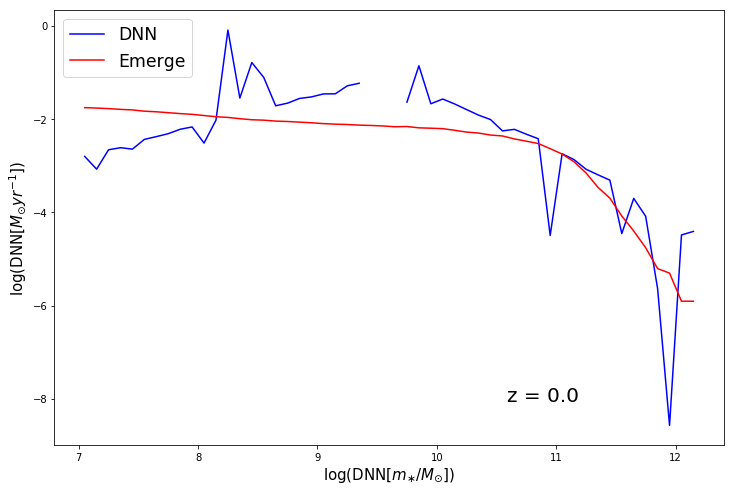

In [162]:
fig73 = get_ssfr_plot(model, training_data_dict, unit_dict, galaxies=None, title=None, data_type='test')

In [163]:
fig73.savefig(fig_dir + 'ssfr_as_loss_func.png', bbox_inches = 'tight')

#### Get standard pictures

In [103]:
fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'Stellar_mass', pso=True, title=title, data_type=mode,
                                   predicted_points = predicted_points, galaxies=galaxies)

fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, pso=True, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)

fig3 = get_halo_stellar_mass_plots(model, training_data_dict, unit_dict, pso=True, title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)
fig4 = get_stellar_mass_sfr_plots(model, training_data_dict, unit_dict, pso=True, title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)
fig5 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, pso=True, predicted_feat = 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)
plt.show

KeyError: 'y_train'

<Figure size 864x1152 with 0 Axes>

In [ ]:
fig6 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Halo_mass', 
                                 y_axis_feature = 'Stellar_mass', pso=True, title=title, data_type=mode, marker_size=20, predicted_points=predicted_points,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
# fig7 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Stellar_mass', 
#                                  y_axis_feature = 'SFR', pso=True, title=title, data_type=mode, marker_size=20,
#                                  y_min=None, y_max=None, x_min=None, x_max=None)
plt.show

In [ ]:
fig6.savefig(fig_dir + 'proof_of_concept_3x3_net_one_output_no_weighing.png', bbox_inches = 'tight')

In [ ]:
mode = 'train'
network.pso_swarm.set_best_weights('train')
norm_score = network.pso_swarm.evaluate_model(mode)
tot_score = norm_score
model = network.model
title = 'Inputs: %s\ntest mse %.3e, %s data' % (', '.join(input_features), tot_score, mode)

fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'SFR', title=title, mode=mode)
fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, mode=mode)
fig3 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'Stellar_mass', title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, mode=mode)
fig4 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, mode=mode)
fig5 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'SFR', title=title, y_max = 10, y_min = None,
                                    x_min = None, x_max = None, mode=mode)

plt.show

In [ ]:
%matplotlib inline
nBins = 8
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

predictedY = model.predict(x_test)

for i, feat in enumerate(output_features):
    
    
    ### Plot 1
    fig = plt.figure(figsize=(16,16))
    ax = plt.subplot(211)
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    plt.title('nIterations: %d, training set size: %d, test mse score: %.2e\n' % (nIterations, 
        train_size, testScore) + 
        '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
        len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
        test_size), y=1.03, fontsize=20)
    plt.show
        
    if save_figs:
        fig.savefig(fig_dir+'pso_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
    
    ### Plot 2 - boxplot
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,i], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,i], predictedY[:,i].flatten(), bins=bin_edges)
    bin_centers = []
    for iBin in range(nBins):
        bin_centers.append((bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2)
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
    
    fig = plt.figure(figsize=(16,8))
    ax = plt.subplot(212)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every boxplot adds 2 boxes, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.boxplot([sorted_true_y_data[iBin], sorted_pred_y_data[iBin]] , positions = bin_pos, widths = 0.9)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers) TODO fixa siffrorna
    plt.text(12,7,'Left: true data. Right: predicted data.', fontsize=20)
    
    if feat == 'SFR':
        ax.axhline(y=0, linestyle='--')
    
    #plt.title('nIterations: %d, training set size: %d, test mse score: %.2e\n' % (nIterations, 
    #    train_size, testScore) + 
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    
    plt.show()
    
    if save_figs:
        fig.savefig(fig_dir+'pso_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

In [ ]:
# Summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(trainingScoreHistory, 'b')
plt.plot(validationScoreHistory, 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()